In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForTokenClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


# BERT Learning Code

In [ ]:
new_df = pd.read_pickle("tokens.df")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([[2, 2, 2,  ..., 0, 0, 0],
        [2, 2, 2,  ..., 0, 0, 0]])
Epoch: 1 Train Loss: 1.0897256135940552 Val Loss: 0.9129695892333984 F1 Score: 0.45978903323970033
tensor([[2, 2, 2,  ..., 0, 0, 0],
        [2, 2, 2,  ..., 0, 0, 0]])
Epoch: 2 Train Loss: 0.7866235971450806 Val Loss: 0.788357138633728 F1 Score: 0.6398642216135094
tensor([[2, 2, 2,  ..., 0, 0, 0],
        [2, 2, 2,  ..., 0, 0, 0]])
Epoch: 3 Train Loss: 0.6778031587600708 Val Loss: 0.662930965423584 F1 Score: 0.8043514354164305
tensor([[2, 2, 2,  ..., 0, 0, 0],
        [2, 2, 2,  ..., 0, 0, 0]])
Epoch: 4 Train Loss: 0.572088897228241 Val Loss: 0.5565863847732544 F1 Score: 0.8634476459586197
tensor([[2, 2, 2,  ..., 0, 0, 0],
        [2, 2, 2,  ..., 0, 0, 0]])
Epoch: 5 Train Loss: 0.44800490140914917 Val Loss: 0.42821288108825684 F1 Score: 0.9121004107214872
tensor([[2, 2, 2,  ..., 0, 0, 0],
        [2, 2, 2,  ..., 0, 0, 0]])
Epoch: 6 Train Loss: 0.3619087338447571 Val Loss: 0.32350146770477295 F1 Score: 0.94277214220868

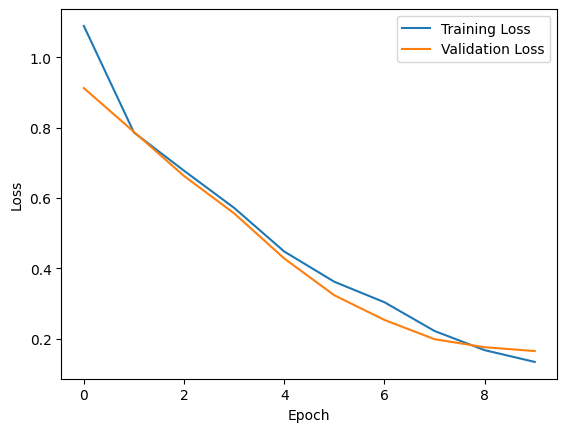

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Extract the tokens and labels columns
random_rows = new_df.sample(n=10)

tokens = random_rows['tokens'].tolist()
labels = random_rows['labels'].tolist()
# Define the BIO labels
BIO_LABELS = ['B-GENOTYPE', 'I-GENOTYPE', 'O']

# Convert the tokens and labels into the format required by the BERT model
input_ids = []
attention_masks = []
label_ids = []
for token_list, label_list in zip(tokens, labels):
    input_ids.append(tokenizer.convert_tokens_to_ids(token_list))
    attention_mask = [1] * len(token_list)
    attention_masks.append(attention_mask)
    label_id = [BIO_LABELS.index(label) for label in label_list]
    label_ids.append(label_id)

# Pad the sequences to the same length
max_length = 512
input_ids = pad_sequences(input_ids, maxlen=max_length, dtype="long", value=0.0, truncating="post", padding="post").tolist()
attention_masks = pad_sequences(attention_masks, maxlen=max_length, dtype="long", value=0.0, truncating="post", padding="post").tolist()
label_ids = pad_sequences(label_ids, maxlen=max_length, dtype="long", value=0.0, truncating="post", padding="post").tolist()

# Convert the data into PyTorch tensors
input_ids = torch.tensor(input_ids, dtype=torch.long)
attention_masks = torch.tensor(attention_masks, dtype=torch.long)
label_ids = torch.tensor(label_ids, dtype=torch.long)

# Split the data into training and validation sets
train_inputs = input_ids[:int(0.8 * len(input_ids))]
train_masks = attention_masks[:int(0.8 * len(attention_masks))]
train_labels = label_ids[:int(0.8 * len(label_ids))]
val_inputs = input_ids[int(0.8 * len(input_ids)):]
val_masks = attention_masks[int(0.8 * len(attention_masks)):]
val_labels = label_ids[int(0.8 * len(label_ids)):]

# Create a PyTorch dataset and dataloader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=32)

# Initialize the BERT model and optimizer
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(BIO_LABELS))
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

# Train the model
epochs = 10
train_loss = []
val_loss = []
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)
        batch_labels = batch_labels.view(-1, batch_labels.size(1))  # Reshape labels tensor
        optimizer.zero_grad()
        model.to(device)
        outputs = model(batch_input_ids, token_type_ids=None, attention_mask=batch_attention_masks, labels=batch_labels)
        total_train_loss += outputs[0].item()
        outputs[0].backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_loss.append(avg_train_loss)
    model.eval()
    total_val_loss = 0
    val_preds = []
    for batch in val_dataloader:
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)
        with torch.no_grad():
            outputs = model(batch_input_ids, token_type_ids=None, attention_mask=batch_attention_masks, labels=batch_labels)
        total_val_loss += outputs[0].item()
        logits = outputs[1].detach().cpu().numpy()
        label_ids = batch_labels.to('cpu').numpy()
        val_preds.extend([list(p) for p in np.argmax(logits, axis=2)])
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_loss.append(avg_val_loss)
    val_preds = [p for pred in val_preds for p in pred]
    print(val_labels)
    val_labels_1 = [l for label in val_labels for l in label]
    f1 = f1_score(val_labels_1, val_preds, average='weighted')
    print('Epoch:', epoch + 1, 'Train Loss:', avg_train_loss, 'Val Loss:', avg_val_loss, 'F1 Score:', f1)

# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()